In [1]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### Test MTCNN face detection model

In [2]:

class MTCNNDetector:
    """MTCNN face detector - more accurate, handles alignment automatically"""
    
    def __init__(self, device='cpu', image_size=160):
        """
        Initialize MTCNN detector
        
        Args:
            device: 'cpu' or 'cuda'
            image_size: Output face size (default 160 for FaceNet)
        """
        self.device = device
        self.mtcnn = MTCNN(
            image_size=image_size,
            margin=0,
            min_face_size=20,
            thresholds=[0.6, 0.7, 0.7],
            factor=0.709,
            post_process=True,
            device=device,
            select_largest=True  # Select largest face if multiple detected
        )
    
    def detect_and_align(self, image):
        """
        Detect and align face from image
        
        Args:
            image: PIL Image or numpy array
            
        Returns:
            torch.Tensor: Aligned face tensor (3, 160, 160) or None if no face detected
        """
        try:
            face_tensor = self.mtcnn(image)
            return face_tensor
        except Exception as e:
            logger.error(f"MTCNN detection error: {e}")
            return None


In [3]:
image_path = "/workspaces/face_duplicate_detection/data/images/Adam Brody_368.jpg"
img = Image.open(image_path)

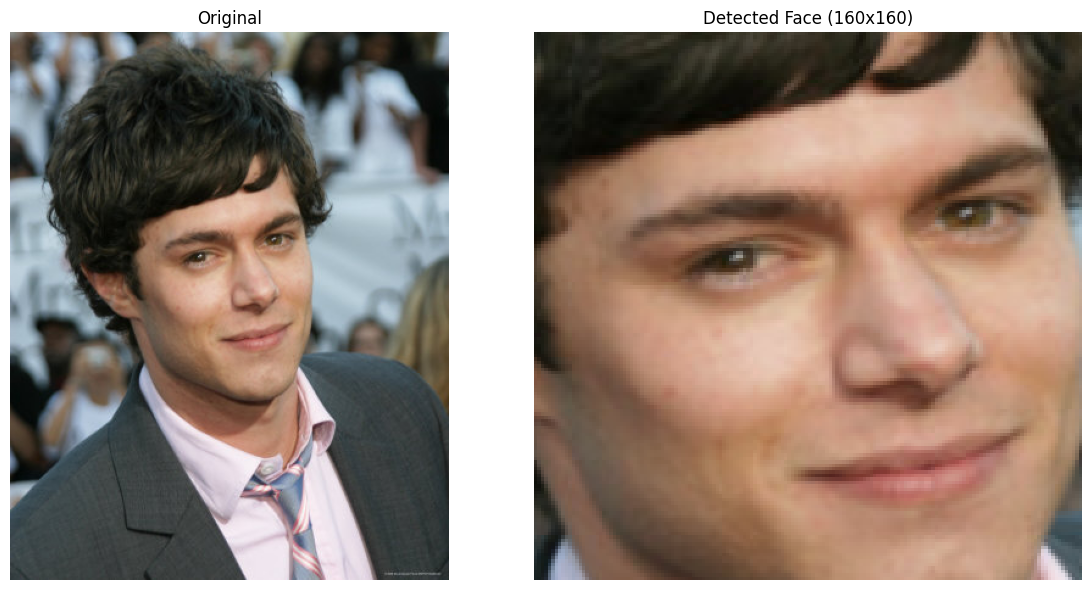

In [4]:
mtcnn = MTCNNDetector(image_size=160, device='cpu')
face_tensor = mtcnn.detect_and_align(img)

# Show side-by-side
if face_tensor is not None:
    face_img = face_tensor.permute(1, 2, 0).numpy()
    face_img = (face_img * 0.5) + 0.5
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(face_img)
    axes[1].set_title('Detected Face (160x160)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No face detected")

### Test Yunet

In [5]:
model_path = "/workspaces/face_duplicate_detection/model/face_detection_yunet_2023mar.onnx"

In [8]:
import cv2
class YuNetDetector:
    """YuNet face detector - faster, requires manual alignment"""
    
    def __init__(self, model_path, device='cpu', image_size=160):
        """
        Initialize YuNet detector
        
        Args:
            model_path: Path to YuNet ONNX model
            device: 'cpu' or 'cuda'
            image_size: Output face size (default 160 for FaceNet)
        """
        self.device = device
        self.image_size = image_size
        
        try:
            self.detector = cv2.FaceDetectorYN.create(
                model_path,
                "",
                (320, 320),
                score_threshold=0.6,
                nms_threshold=0.3
            )
        except Exception as e:
            raise RuntimeError(f"Failed to load YuNet model from {model_path}: {e}")
    
    def detect_and_align(self, image):
        """
        Detect and align face from image
        
        Args:
            image: PIL Image
            
        Returns:
            torch.Tensor: Face tensor (3, 160, 160) or None if no face detected
        """
        try:
            # Convert PIL to OpenCV format
            img = np.array(image)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            height, width = img.shape[:2]
            self.detector.setInputSize((width, height))
            
            # Detect faces
            _, faces = self.detector.detect(img)
            
            if faces is None or len(faces) == 0:
                return None
            
            # Get largest face
            face = faces[0]
            x, y, w, h = face[:4].astype(int)
            
            # Add margin
            margin = int(0.1 * max(w, h))
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(width - x, w + 2*margin)
            h = min(height - y, h + 2*margin)
            
            # Crop face
            face_img = img[y:y+h, x:x+w]
            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
            face_img = cv2.resize(face_img, (self.image_size, self.image_size))
            
            # Convert to tensor and normalize for FaceNet
            face_tensor = torch.FloatTensor(face_img).permute(2, 0, 1) / 255.0
            face_tensor = (face_tensor - 0.5) / 0.5  # Normalize to [-1, 1]
            
            return face_tensor
            
        except Exception as e:
            logger.error(f"YuNet detection error: {e}")
            return None

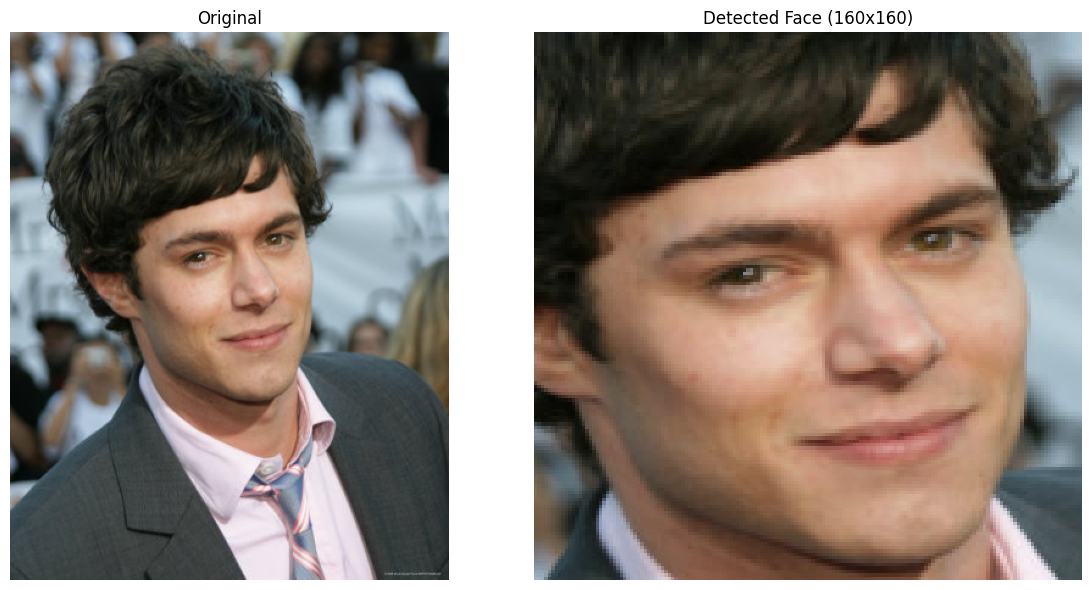

In [9]:
yunet = YuNetDetector(model_path = model_path, image_size=160, device='cpu')
face_tensor = yunet.detect_and_align(img)

# Show side-by-side
if face_tensor is not None:
    face_img = face_tensor.permute(1, 2, 0).numpy()
    face_img = (face_img * 0.5) + 0.5
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(face_img)
    axes[1].set_title('Detected Face (160x160)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No face detected")

### Test image preprocessing

In [17]:
class ImagePreprocessor:
    """Handles image preprocessing for face recognition"""
    
    def __init__(self, max_size=2000):
        """
        Initialize preprocessor
        
        Args:
            max_size: Maximum image dimension (width or height)
        """
        self.max_size = max_size
    
    def preprocess(self, image_path):
        """
        Preprocess image before face detection
        
        Args:
            image_path: Path to image file
            
        Returns:
            PIL.Image: Preprocessed image or None if failed
        """
        try:
            # Load image
            img = Image.open(image_path)
            
            # Fix EXIF orientation (important for phone photos)
            img = ImageOps.exif_transpose(img)
            
            # Ensure RGB format
            if img.mode == 'RGBA':
                # Create white background for transparency
                background = Image.new('RGB', img.size, (255, 255, 255))
                background.paste(img, mask=img.split()[3])
                img = background
            elif img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize large images for performance
            if max(img.size) > self.max_size:
                img.thumbnail((self.max_size, self.max_size), Image.LANCZOS)
            
            return img
            
        except Exception as e:
            print(f"Error preprocessing {image_path}: {e}")
            return None

In [26]:
processor = ImagePreprocessor()
preprocess_image = processor.preprocess(image_path)

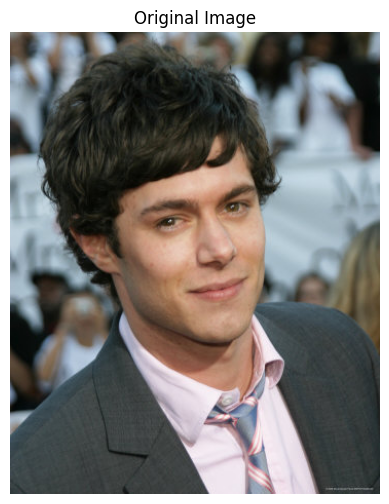

In [27]:
plt.figure(figsize=(6, 6))
plt.imshow(preprocess_image)
plt.title('Original Image')
plt.axis('off')
plt.show()